In [92]:
import numpy as np
import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from scipy.ndimage.filters import gaussian_filter
from typing import List, Tuple
import matplotlib.pyplot as plt
%matplotlib inline

/tmp/ipykernel_4704/3979415708.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [93]:
RANDOM_SEED = 42
N_NODES = 10000
N_SAMPLES = 25000
N_DIMENSIONS = 2 # 2D for now... can experiment w/ 3D later
N_CHANNELS = N_DIMENSIONS + 1 # + 1 for the signal strength  
N_NODES_PER_TRIANGULATION = 5

In [94]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


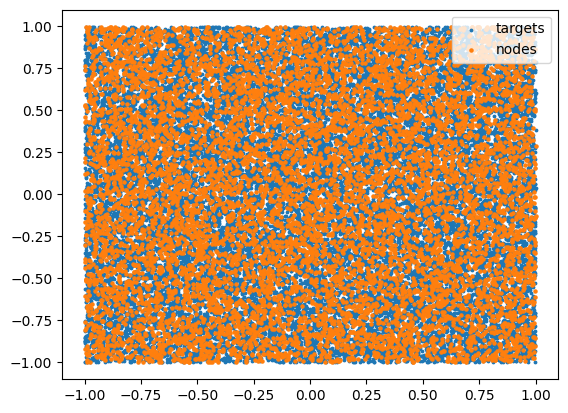

In [95]:
np.random.seed(RANDOM_SEED) 
# Generate nodes and targets at random 2D coordinates
nodes = np.random.uniform(low=-1, high=1, size=(N_NODES, N_DIMENSIONS,))
targets = np.random.uniform(low=-1, high=1, size=(N_SAMPLES, N_DIMENSIONS,))

plt.scatter(x=targets[:,0], y=targets[:,1], s=3, label="targets")
plt.scatter(x=nodes[:,0], y=nodes[:,1], s=5, label="nodes")
plt.legend()

In [96]:
np.random.seed(RANDOM_SEED)
g = torch.Generator().manual_seed(RANDOM_SEED)  # for reproducibility


def build_dataset(
    nodes: Tensor, targets: Tensor, max_noise: float = 0.02
) -> Tuple[Tensor, Tensor]:
    # The inputs will be the location of n nodes and the measured signal strength to each
    # X is a sample... a tensor with the following dims
    #   (batch, N_NODES_PER_TRIANGULATION, channels) 
    #       where channels contains x,y,..,signal_strength
    # The labels will be the target's true coordinates
    X,Y = [],[]
    # For each target, simulate signal strength to n random nodes
    for target in targets:
        # get n random nodes used for simulated triangulation
        node_idxs = np.random.randint(
            low=0, high=nodes.shape[0], size=(N_NODES_PER_TRIANGULATION)
        )
        nodes_xy = nodes[node_idxs]

        # simualte signal strength as the euclidian distancec from each node to the target...
        ss = np.linalg.norm(nodes_xy - target, axis=1)
        # simulate noise in the signal strength
        if max_noise != 0:
            ss += max_noise * np.random.uniform(low=0.0, high=1.0, size=ss.shape)
        
        # X is a sample... a tensor with the following dims
        #   (batch, x, y, signal_strength)
        sample = []
        for node, measurement in zip(nodes_xy, ss):
            sample.append([node[0], node[1], measurement])
        X.append(sample)
        Y.append(target)
    # model will try to predict the triangulated target position...
    # so the label for a target is the target's TRUE x,y coordinates
    X = torch.tensor(X).float().to(device)
    Y = torch.tensor(Y).float().to(device)
    return X, Y


Xtr, Ytr = build_dataset(nodes=nodes, targets=targets)
Xval, Yval = build_dataset(nodes=nodes, targets=targets, max_noise=0)

In [97]:
torch.manual_seed(RANDOM_SEED)

def get_batch(batch_size:int =32, is_train: bool=True):
    # generate a small batch of data of inputs x and targets y
    data = Xtr if is_train else Xval
    labels = Ytr if is_train else Yval
    ix = torch.randint(0, data.shape[0], (batch_size,))
    return data[ix], labels[ix]

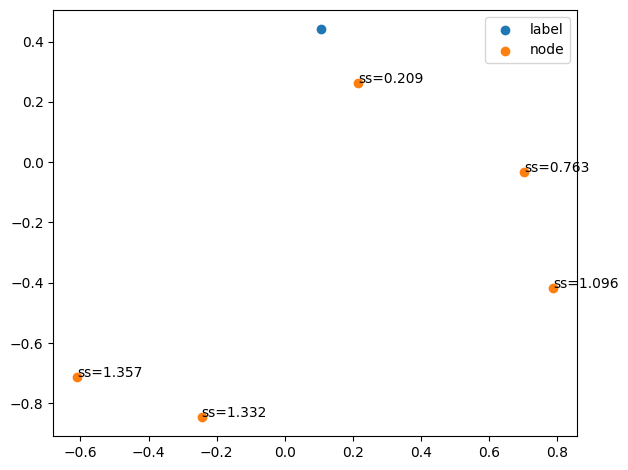

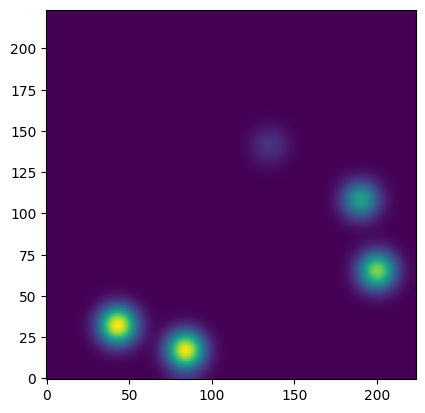

In [98]:
# Let's look at a single sample
samples, labels = get_batch(batch_size=1, is_train=False)
target = labels[0].detach().cpu()
sample = samples[0].detach().cpu()
nodes_x = [data[0] for data in sample]
nodes_y = [data[1] for data in sample]
measured_ss = [data[2] for data in sample]
plt.scatter(x=target[0], y=target[1], label="label")
plt.scatter(
    x=nodes_x,
    y=nodes_y,
    label="node",
)
for x, y, ss in zip(nodes_x, nodes_y, measured_ss):
    plt.annotate(f"ss={ss.item():.3f}", xy=(x, y))
plt.tight_layout()
plt.legend()

# Alternatively -- try converting it to a signal strength heatmap (for CNN models)
plt.figure()
im_size = 224
img = np.zeros((im_size, im_size), np.float32)
for x,y,ss in sample:
    x = int((x.item() + 1.0) / 2.0 * im_size)
    y = int((y.item() + 1.0) / 2.0 * im_size)
    img[y,x] = ss.item()
plt.imshow(img, origin='lower')
plt.imshow(gaussian_filter(img, sigma=8), origin='lower')


In [99]:
# Linear Regression
# from sklearn.linear_model import LinearRegression
# x_train = Xtr.numpy().reshape((Xtr.shape[0], -1))
# y_train = Ytr.numpy()
# x_val = Xval.numpy().reshape((Xval.shape[0], -1))
# y_val = Yval.numpy()
# reg = LinearRegression()
# reg.fit(x_train, y_train)

# preds = reg.predict(x_val)
# euclidean_err = np.linalg.norm(preds - y_val, axis=1)
# print(euclidean_err.mean())


In [100]:
class MlpTriangulationModel(nn.Module):
    def __init__(
        self, hidden_layer_size: int = 64, n_hidden_layers: int = 5, b_norm: bool = True
    ):
        super().__init__()
        fan_in_out = [
            (N_NODES_PER_TRIANGULATION * (N_DIMENSIONS + 1), hidden_layer_size)
        ] + (n_hidden_layers - 1) * [(hidden_layer_size, hidden_layer_size)]
        layers = [
            # Flatten the data for each node into a single vector like so: [x1,y1,ss1, x2,y2,ss2...]
            nn.Flatten(start_dim=1)
        ]
        for fan_in, fan_out in fan_in_out:
            layers += (
                [nn.Linear(fan_in, fan_out, bias=not b_norm)]
                + ([nn.BatchNorm1d(fan_out)] if b_norm else [])
                + [nn.ReLU()]
            )

        layers.append(nn.Linear(fan_in_out[-1][-1], N_DIMENSIONS))
        # parameter init
        with torch.no_grad():
            layers[-1].weight *= 0.1  # make last layer less confident
        self.layers = nn.Sequential(*layers)

    def forward(self, samples: Tensor, targets: Tensor = None) -> Tuple[Tensor, Tensor]:
        logits = self.layers(samples)
        if targets is None:
            loss = None
        else:
            loss = F.mse_loss(logits, targets)
            # loss = F.l1_loss(logits, targets)
        return logits, loss


In [101]:
n_embd = 24
n_head = 4
n_layer = 4
dropout = 0.2

# Transofrmer model
class Head(nn.Module):
    """one head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        k = self.key(x)  # (B.N,C)
        q = self.query(x)  # (B.N,C)
        # compute attention scores ("affinities")
        wei = (
            q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5
        )  # (B, N, C) @ (B, C, N) -> (B, N, N)
        wei = F.softmax(wei, dim=-1)  # (B, N, N)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)  # (B.N,C)
        out = wei @ v  # (B, N, N) @ (B, N, C) -> (B, N, C)
        return out


class MultiHeadAttention(nn.Module):
    """multiple heads of self-attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedFoward(nn.Module):
    """a simple linear layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class TransformerTriangulationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.channel_embedding = nn.Linear(N_CHANNELS, n_embd)
        self.blocks = nn.Sequential(
            *[Block(n_embd, n_head=n_head) for _ in range(n_layer)]
        )
        self.ln_f = nn.LayerNorm(n_embd)  # final layer norm
        self.flatten = nn.Flatten(start_dim=1)
        self.lm_head = nn.Linear(N_NODES_PER_TRIANGULATION * n_embd, N_DIMENSIONS)

    def forward(self, samples, targets=None):
        x = self.channel_embedding(samples)  # (B.N,C)
        x = self.blocks(x)  # (B.N,C)
        x = self.ln_f(x)  # (B.N,C)
        x = self.flatten(x)  # (B.N*C)
        logits = self.lm_head(x)  # (B.NDim)

        if targets is None:
            loss = None
        else:
            B, C = logits.shape
            B, C = targets.shape
            loss = F.mse_loss(logits, targets)

        return logits, loss


In [102]:
from torchvision.models import resnet18
class ImageTriangulationModel(nn.Module):
    def __init__(self, size:int=224):
        super(ImageTriangulationModel, self).__init__()
        self.size=size
        resnet = resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.head = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, N_DIMENSIONS))
        
    def forward(self, samples:Tensor, targets:Tensor=None)->Tuple[Tensor, Tensor]:
        img = np.zeros((samples.shape[0], 3, im_size, im_size), np.float32)
        for i, sample in enumerate(samples):
            for x,y,ss in sample:
                x = int((x.item() + 1.0) / 2.0 * (self.size-1))
                y = int((y.item() + 1.0) / 2.0 * (self.size-1))
                img[i, :, y, x] = ss.item()
        x = torch.Tensor(img).to(device)
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        logits = self.head(x)
        
        if targets is None:
            loss = None
        else:
            loss = F.mse_loss(logits, targets)

        return logits, loss

In [103]:
# Create model
model = MlpTriangulationModel()
# model = TransformerTriangulationModel()
# model = ImageTriangulationModel()

model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

0.018114 M parameters


In [104]:
# Training
BATCH_SIZE = 64
MAX_STEPS = 15000
LR_DECAY = [MAX_STEPS//3, 4*MAX_STEPS//5]
PRINT_INTERVAL = MAX_STEPS // 25
stats = []

def evaluate(data:Tensor, labels:Tensor)->Tuple[float, float]:
    with torch.no_grad():
        predictions, _ = model(data)
    euclidean_err = np.linalg.norm(predictions.cpu().numpy() - labels.cpu().numpy(), axis=1)
    return euclidean_err.mean(), euclidean_err.std()


model.train()
for i in range(MAX_STEPS):
    # Get a random batch
    Xb, Yb = get_batch(batch_size=BATCH_SIZE, is_train=True)

    # Predict coordinates and evaluate loss
    logits, loss = model(Xb,Yb)
    # Backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if i in LR_DECAY:
        print("Adjusting LR")
        for g in optimizer.param_groups:
            g['lr'] *= 0.1
    step_stats = {
        "step": i,
        "loss": loss.item()
    }
    if i % PRINT_INTERVAL == 0:
        with torch.no_grad():
            val_error_mean, val_error_std = evaluate(data=Xval, labels=Yval)
            step_stats["val_error_mean"] = val_error_mean
            step_stats["val_error_std"] = val_error_std
        print(f"Step: {i},\t Loss: {loss.item():.6f},\tValErr: {val_error_mean:.4f} (std:: {val_error_std:.4f})")
    stats.append(step_stats)

Step: 0,	 Loss: 0.284112,	ValErr: 0.7606 (std:: 0.3013)
Step: 600,	 Loss: 0.064336,	ValErr: 0.2798 (std:: 0.1762)
Step: 1200,	 Loss: 0.048656,	ValErr: 0.2240 (std:: 0.1596)
Step: 1800,	 Loss: 0.060418,	ValErr: 0.2000 (std:: 0.1442)
Step: 2400,	 Loss: 0.033299,	ValErr: 0.1890 (std:: 0.1421)
Step: 3000,	 Loss: 0.030977,	ValErr: 0.1919 (std:: 0.1446)
Step: 3600,	 Loss: 0.053456,	ValErr: 0.1897 (std:: 0.1369)
Step: 4200,	 Loss: 0.048221,	ValErr: 0.1625 (std:: 0.1362)
Step: 4800,	 Loss: 0.026430,	ValErr: 0.1608 (std:: 0.1224)
Adjusting LR
Step: 5400,	 Loss: 0.016797,	ValErr: 0.1256 (std:: 0.1068)
Step: 6000,	 Loss: 0.010619,	ValErr: 0.1191 (std:: 0.1013)
Step: 6600,	 Loss: 0.015964,	ValErr: 0.1182 (std:: 0.0980)
Step: 7200,	 Loss: 0.015954,	ValErr: 0.1156 (std:: 0.0975)
Step: 7800,	 Loss: 0.015589,	ValErr: 0.1147 (std:: 0.0968)
Step: 8400,	 Loss: 0.017190,	ValErr: 0.1129 (std:: 0.0969)
Step: 9000,	 Loss: 0.009549,	ValErr: 0.1105 (std:: 0.0950)
Step: 9600,	 Loss: 0.016993,	ValErr: 0.1141 (st

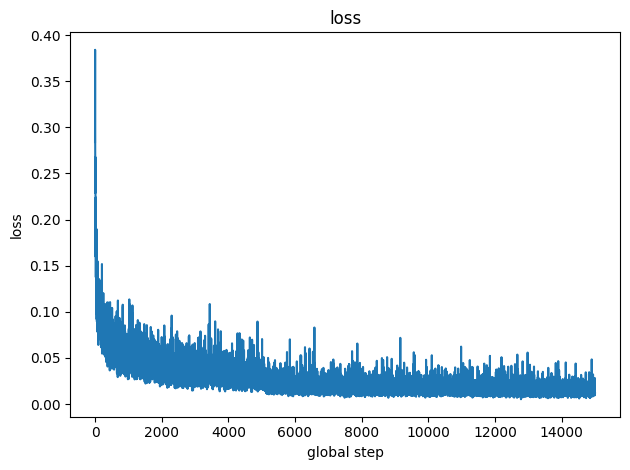

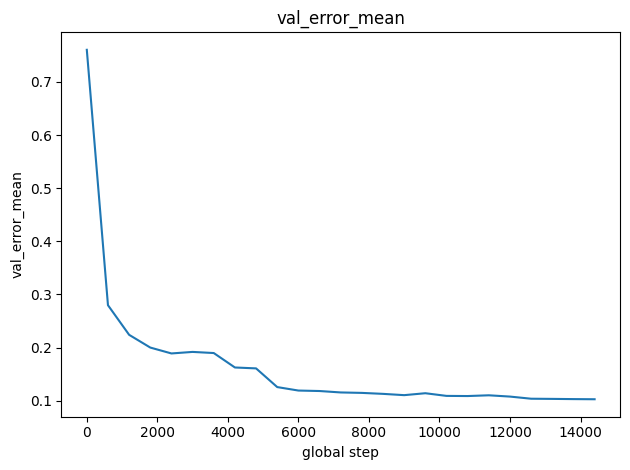

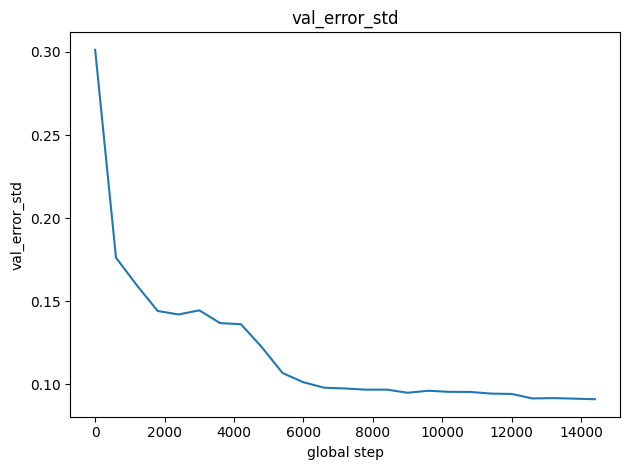

In [105]:
plot_contents = {}
for i, step_stats in enumerate(stats):
    step = step_stats.pop("step", i)
    for k, v in step_stats.items():
        if k not in plot_contents:
            plot_contents[k] = {"x": [], "y":[]}
        plot_contents[k]["x"].append(step)
        plot_contents[k]["y"].append(v)
for k, v in plot_contents.items():
    x, y = np.asarray(v["x"]), np.asarray(v["y"])
    plt.figure()
    plt.title(k)
    plt.plot(x, y)
    plt.xlabel("global step")
    plt.ylabel(k)
    plt.tight_layout()


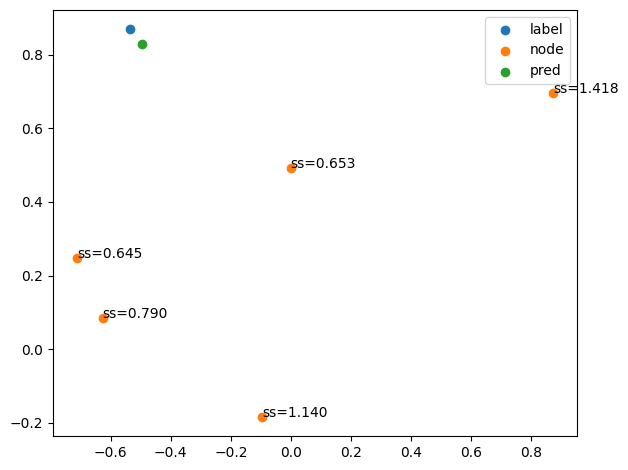

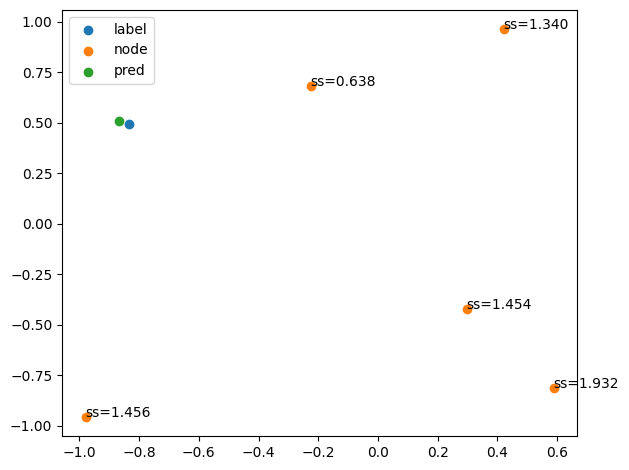

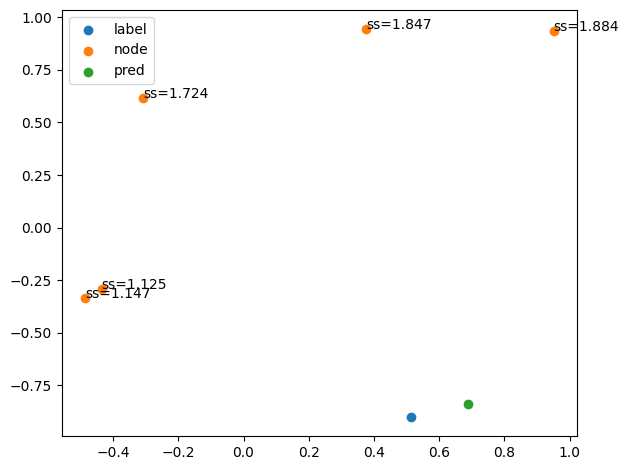

In [106]:
# Predict
samples, labels = get_batch(batch_size=3, is_train=False)
model.eval()
predictions, _ = model(samples)
for sample, target, pred in zip(samples.cpu(), labels.cpu(), predictions.cpu()):
    nodes_x = [data[0] for data in sample]
    nodes_y = [data[1] for data in sample]
    measured_ss = [data[2] for data in sample]
    plt.figure()
    plt.scatter(x=target[0], y=target[1], label="label")
    plt.scatter(
        x=nodes_x,
        y=nodes_y,
        label="node",
    )
    for x, y, ss in zip(nodes_x, nodes_y, measured_ss):
        plt.annotate(f"ss={ss.item():.3f}", xy=(x, y))
    plt.scatter(x=pred[0].item(), y=pred[1].item(), label="pred")
    plt.tight_layout()
    plt.legend()